**Chapter 7: Assumptions**

Just like before, we are assuming some things are true if we fit a model. Therefore, we need to **check our assumptions** before we use a model to predict values in the future (to make sure it's actually a good model)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

df = pd.read_csv('https://www.ishelp.info/data/insurance.csv')

# Set label and features
y = df['charges']                    
X = df.select_dtypes(np.number).assign(const=1)
X = X.drop(columns=['charges'])

# Run the multiple linear regression model
model = sm.OLS(y, X).fit()
print(model.summary())  # View results

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.120
Model:                            OLS   Adj. R-squared:                  0.118
Method:                 Least Squares   F-statistic:                     60.69
Date:                Tue, 21 Jan 2025   Prob (F-statistic):           8.80e-37
Time:                        18:15:13   Log-Likelihood:                -14392.
No. Observations:                1338   AIC:                         2.879e+04
Df Residuals:                    1334   BIC:                         2.881e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age          239.9945     22.289     10.767      0.0

**Assumptions:**
* **Normality**: Omnibus and Jarque-Bera (safe: p-value *high*)
    * *Residuals* need to be normally distributed
* **Multicollinearity**: Are there strong relationships between any two variables, to the point where an increase/decrease in one will strongly affect the other?
    * *Condition Number (Cond. No.)*: (safe: < 1, but only if normality is met)
    * *VIF:* below 3 (great), 5 (good), 10 (okay)
    * *Tolerance:* above 0.1 (good enough) or 0.2 (better) *(Some sources say cutoff should be 0.25)*
* **Autocorrelation**: How dependent are the variables on *time*? This is a whole other set of statistical analysis called *time series*
    * *Durban-Watson*: Safe between 1 and 2

**Theory**
* VIF: 1 / (1 - R^2)
* Tolerance: 1 - R^2

R^2 is a correlation of one variable based on the other variables in the model

In [2]:
for col in df:  
  if not pd.api.types.is_numeric_dtype(df[col]):
    df = pd.get_dummies(df, columns=[col], prefix=col)

df = df.drop(columns=['sex_female', 'smoker_no', 'region_northeast']).assign(const=1)
df   # with dummy variables

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest,const
0,19,27.900,0,16884.92400,False,True,False,False,True,1
1,18,33.770,1,1725.55230,True,False,False,True,False,1
2,28,33.000,3,4449.46200,True,False,False,True,False,1
3,33,22.705,0,21984.47061,True,False,True,False,False,1
4,32,28.880,0,3866.85520,True,False,True,False,False,1
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,True,False,True,False,False,1
1334,18,31.920,0,2205.98080,False,False,False,False,False,1
1335,18,36.850,0,1629.83350,False,False,False,True,False,1
1336,21,25.800,0,2007.94500,False,False,False,False,True,1


**Residuals**: Difference between actual values and those predicted by our model.

What does this mean??
* **Actual**: Charges made to insurance by each person
* **Predicted**: If we plug-and-chug age, bmi, etc., for each person in our dataset into the model we created, what does our model say the charges to insurance would be?

We subtract one from the other to get a difference between the two. It's like rechecking to see how well our model would work if we had the same people, same data, but we wanted to predict their charges to insurance.

In [3]:
df_insample = pd.DataFrame({'Actual':df['charges'], 
                            'Predicted':model.fittedvalues, 
                            'Residuals (Error)':df['charges'] - model.fittedvalues})

df_insample.head(10)

,Actual,Predicted,Residuals (Error)
0,16884.92400,6908.777533,9976.146467
1,1725.55230,9160.977061,-7435.424761
2,4449.46200,12390.946918,-7941.484918
3,21984.47061,8543.527095,13440.943515
4,3866.85520,10354.147396,-6487.292196
5,3756.62160,9071.411158,-5314.789558
6,8240.58960,15771.234831,-7530.645231
7,7281.50560,12804.138689,-5522.633089
8,6406.41070,12955.328269,-6548.917569
9,28923.13692,16064.459249,12858.677671


**Pairplots**: When using multiple variables to predict another value, we NEED to make sure the variables don't have any direct relationship to each other! This means we would need to include this relationship in our model (such as an *interaction*)

If we run a pairplot, we can quickly see if any individual variables have a relationship with each other. If you see a pattern, such as a *line, groupings, curves, etc.*, then there could be a relationship between two individual variables.

*We DON'T want patterns, but if we see it, we need to address it in our model.* For now, just learn to recognize potential issues.

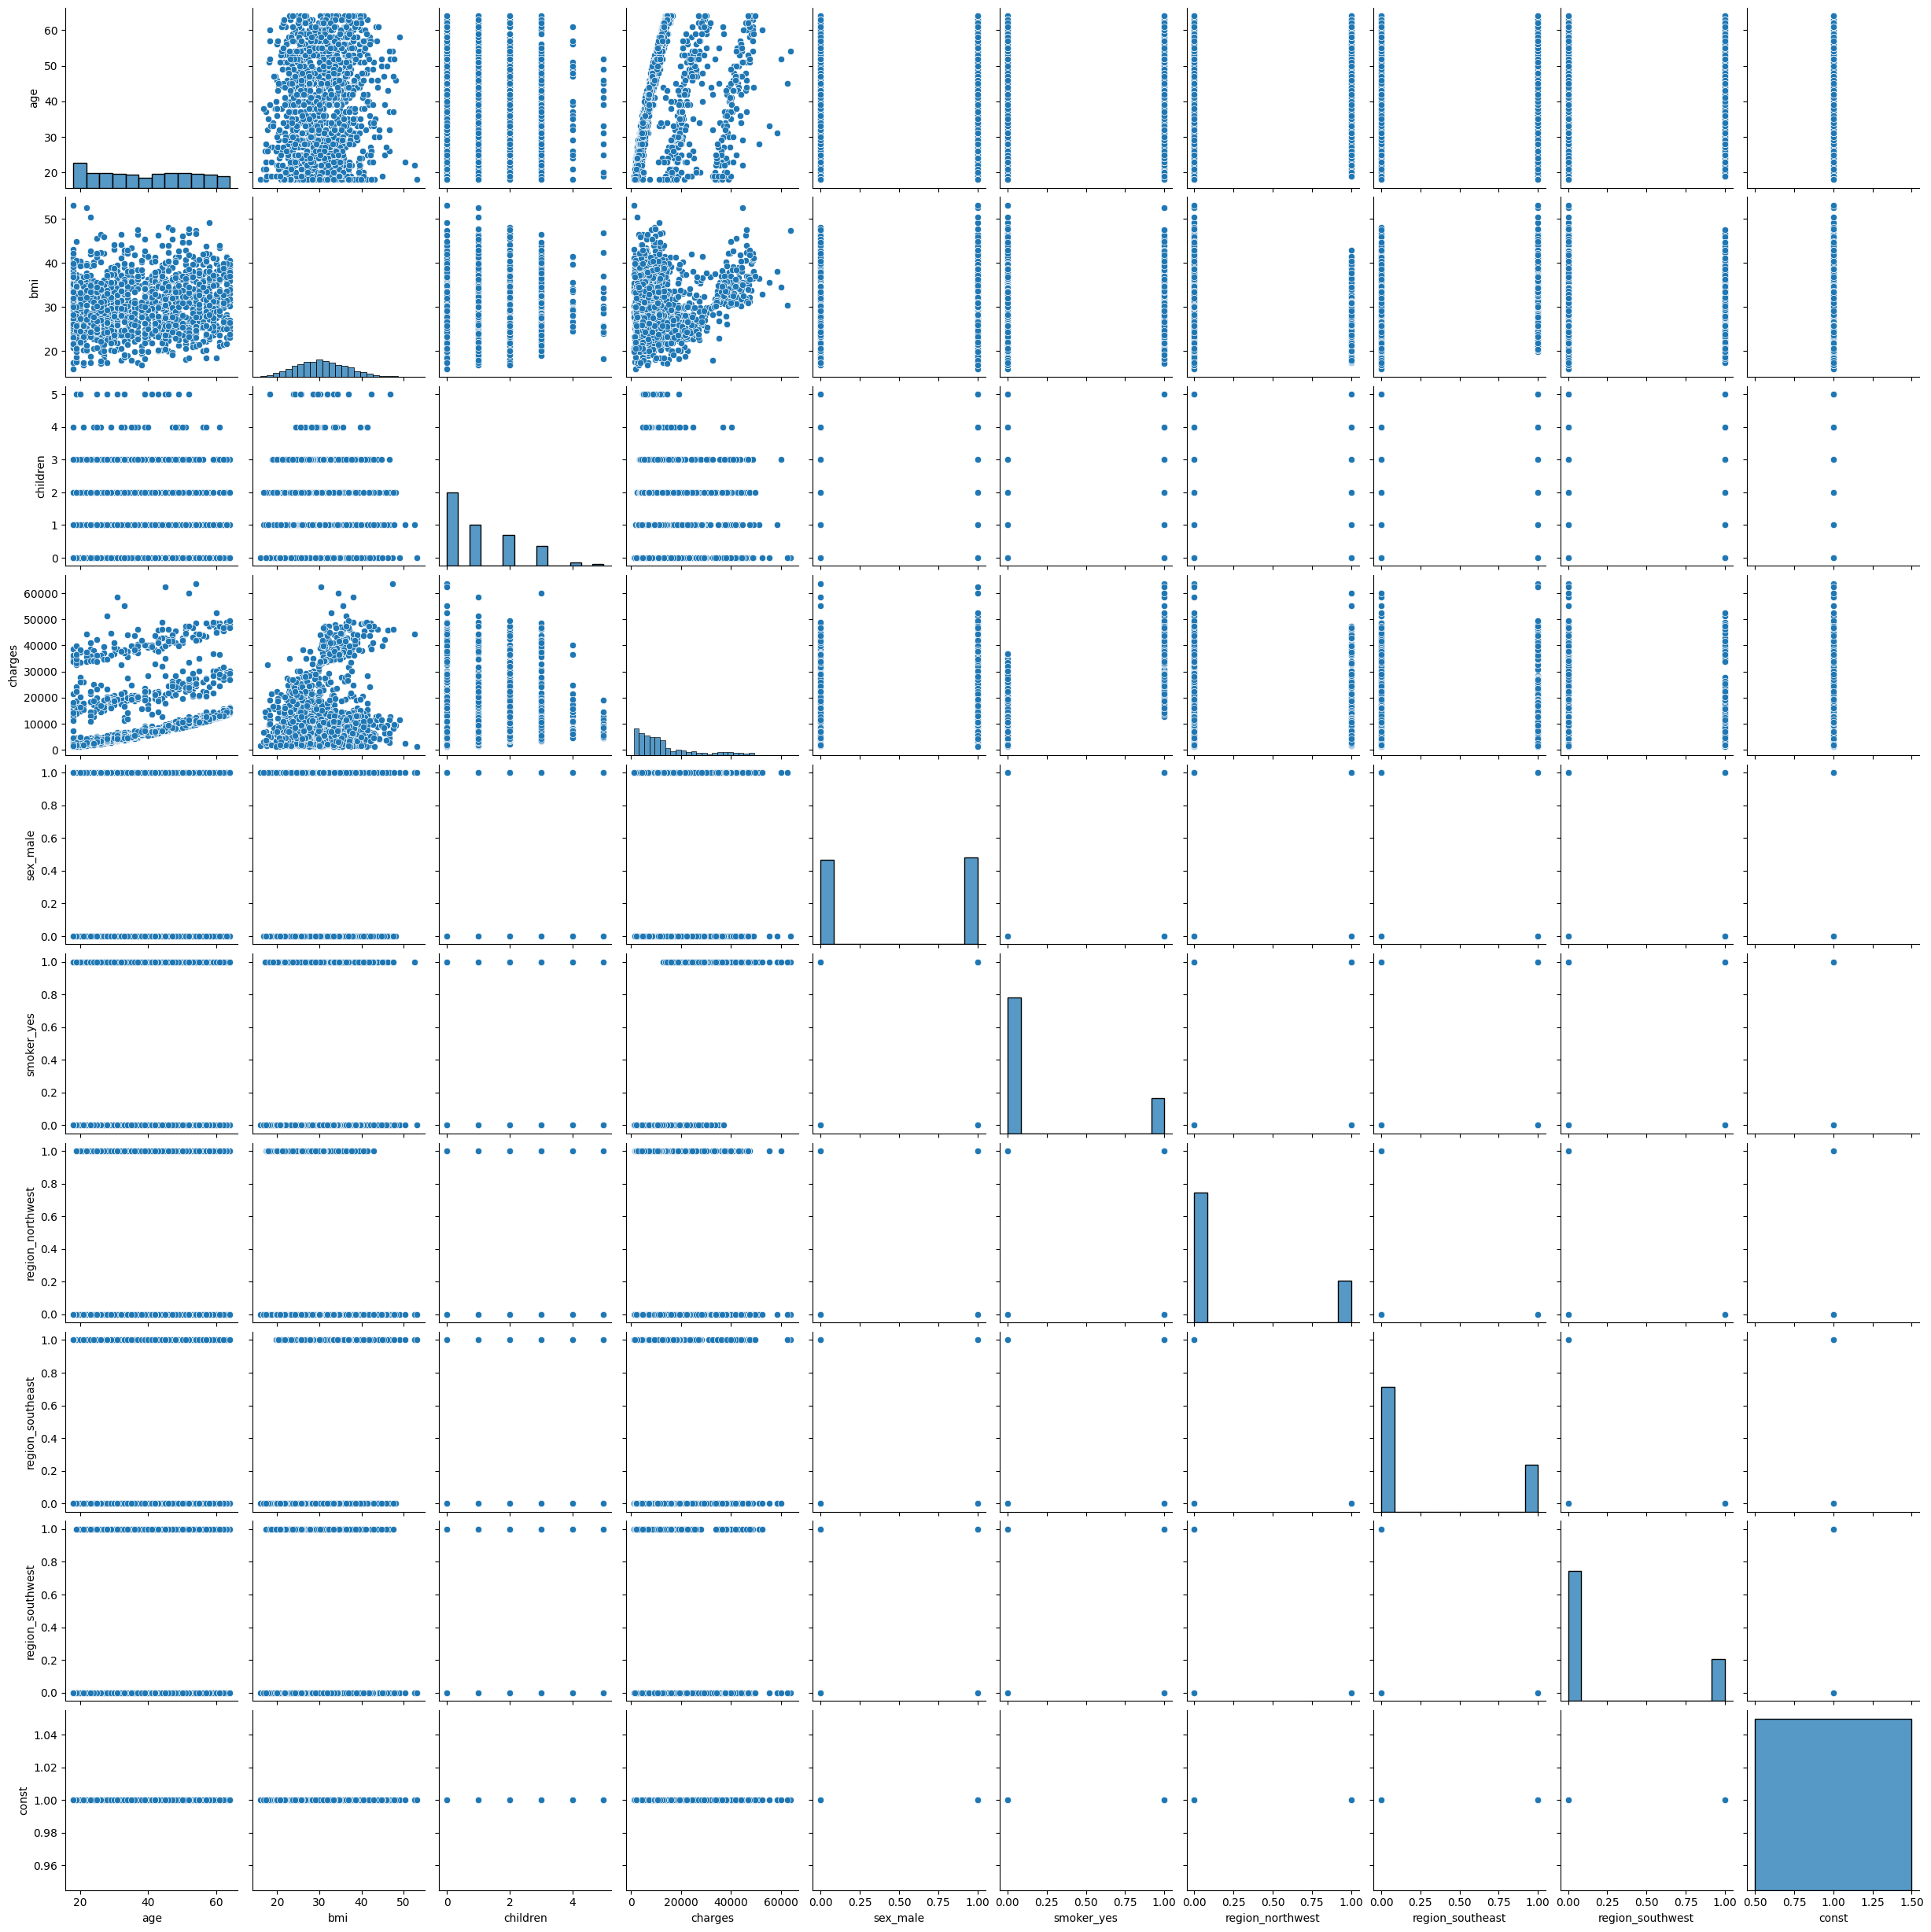

In [4]:
sns.pairplot(df);

**Normality**: We want residuals to be normally distributed. We can check this easily with the following two plots:
1. Residuals vs. Fitted Values (Predicted by the model)
2. Probability Plot (This is MUCH easier to check)

**Residuals vs. Fitted Values**: The following should be scattered nicely, but it's not. We see some patterns. **Uh oh...**

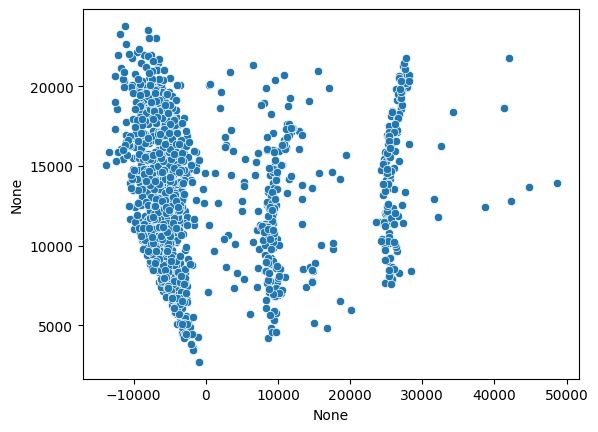

In [5]:
pred_val = model.fittedvalues.copy()
true_val = df['charges'].values.copy()
residual = true_val - pred_val

ax = sns.scatterplot(x=residual, y=pred_val)

**Probability Plot**: We want to see our *blue dots follow as much of the red straight line as possible*, and we DEFINITELY don't want to see any patterns.

Often, we might see the top and bottom parts trail away from the red line, which is an indicator that our normality assumption is NOT met.

The following plot shows a clear pattern away from the red line. We have an issue.

np.float64(0.7521581906013642)

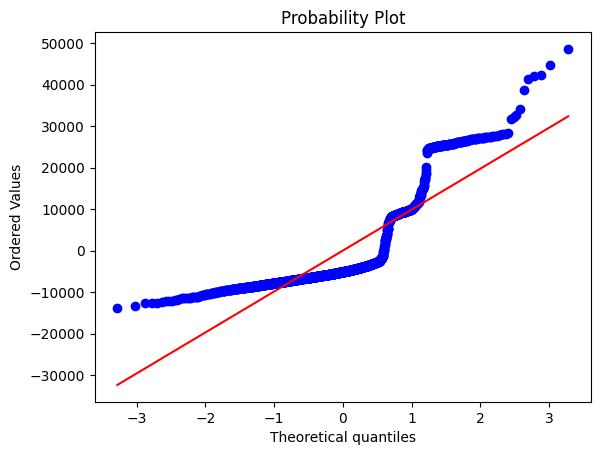

In [6]:
import scipy as sp
fig, ax = plt.subplots()
_, (__, ___, r) = sp.stats.probplot(residual, plot=ax, fit=True)
r**2

**Omnibus and JB Tests**: Go back up to our output. Remember, these tests are testing **if there is an issue with normality.**

Therefore, if the p-value is really low, then what we are testing for is found! What are we testing for? Problems with normality!

We have an extremely low p-value. THEREFORE... there's a problem with normality!

In [7]:
import statsmodels.api as sm

# Create a blank DataFrame to store the results
df_vif = pd.DataFrame(columns=['VIF', 'Tolerance'])
df = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns, drop_first=True)

for col in df.drop(columns=['charges']):
  y = df[col]
  X = df.drop(columns=[col, 'charges']).assign(const=1)
  
  r_squared = sm.OLS(y, X).fit().rsquared

  if r_squared < 1: # Prevent division by zero runtime error
    df_vif.loc[col] = [1/(1 - r_squared), 1 - r_squared]
  else:
    df_vif.loc[col] = ['infinity', 1 - r_squared]

df_vif.sort_values(by=['VIF'], ascending=False)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

The book explains a little more about the Multicollinearity and Autocorrelation assumptions and this example. However, we can look at the VIF and Tolerance levels above, and refer back to what's considered "good" above.

Looks like our Multicollinearity and Autocorrelation assumptions are met! **So, we're at least good there!**